In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy import stats
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
X_train = mnist.train.images
X_test = mnist.test.images
Y_train = mnist.train.labels
Y_test = mnist.test.labels

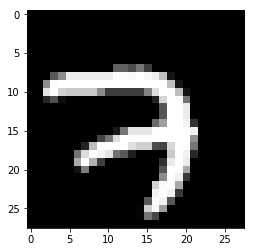

In [3]:
plt.imshow(X_train[0,:].reshape(28,28), cmap="gray")

In [4]:
def one_hot_encode_with_loops(y):
    encoded = np.zeros((len(y), np.max(y)+1), dtype="uint8")
    for i in range(len(y)):
        encoded[i, y[i]] = 1
    assert len(y) == encoded.shape[0]    
    return encoded


print(one_hot_encode_with_loops(np.r_[5,6,7]))
print('\n')
print(one_hot_encode_with_loops(np.r_[5,6,7,5]))

[[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


[[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]]


In [5]:
def one_hot_encode(y):
    encoded = np.zeros((len(y), np.max(y)+1), dtype="uint8")
    encoded[np.arange(len(y)), y] = 1
    assert len(y) == encoded.shape[0]    
    return encoded


print(one_hot_encode(np.r_[5,6,7]))
print('\n')
print(one_hot_encode(np.r_[5,6,7,5]))

[[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


[[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]]


In [6]:
def one_hot_decode(y):
    y = np.argmax(y, axis=1)
    assert(len(y) == y.shape[0])
    return y

In [7]:
# test cases:
assert np.all(one_hot_decode(one_hot_encode_with_loops(Y_train)) == Y_train)
assert np.all(one_hot_decode(one_hot_encode_with_loops(Y_test)) == Y_test)

assert np.all(one_hot_decode(one_hot_encode(Y_train)) == Y_train)
assert np.all(one_hot_decode(one_hot_encode(Y_test)) == Y_test)

In [8]:
Y_train2 = one_hot_encode(Y_train)
Y_test2 = one_hot_encode(Y_test)

In [9]:
X_train.shape

(55000, 784)

In [10]:
# add a column of 1s as the new first column in X_train and X_test as the bias term 'c' in y = mx + c
X_train2 = np.insert(X_train, 0, 1, axis=1)
print(X_train2.shape)
X_test2 = np.insert(X_test, 0, 1, axis=1)
print(X_test2.shape)

assert(np.all(X_train2[:,0] == 1.0))
assert(X_train2.shape[1] == X_train.shape[1]+1)

assert(np.all(X_test2[:,0] == 1.0))
assert(X_test2.shape[1] == X_test.shape[1]+1)

(55000, 785)
(10000, 785)


# Exponential function to model probabilities in logistic regression

1. exp has range (0, infinity), always positive. f(a,x)
2. differentiable
3. Fitting a model is about finding a's so that f(a,x) models probability p(y=1/x)


In [11]:
def softmax(Y):
    Z = np.zeros(Y.shape)
    """
    input: Y - real-valued matrix n*10
    output:Z - (0, 1) valued matrix , shape n*10
    
    """
    Yexp = np.exp(Y)

    #without reshaping np.sum(Yexp, axis=1) will be of dim (1,n) becaus of shape broadcasting-add 1 to the beggining to match the bigger dim in this case n * 10)
    #ValueError: operands could not be broadcast together with shapes (324523,10) (324523,) 
    
    Z = Yexp / np.sum(Yexp, axis=1).reshape(-1,1)
    
    assert(np.all(Z > 0.0))
    assert(np.all(Z < 1.0))
    assert np.all(np.abs(np.sum(Z, axis=1) - 1.0) < 1e-6)
    return Z  

softmax(np.random.rand(324523,10))
softmax(np.random.rand(666,10))

array([[ 0.12329188,  0.1299769 ,  0.14773021, ...,  0.07997212,
         0.06872342,  0.08614006],
       [ 0.07494209,  0.07616166,  0.08631483, ...,  0.11815651,
         0.17038993,  0.07219773],
       [ 0.09112277,  0.0892307 ,  0.06860778, ...,  0.09890484,
         0.1386554 ,  0.09602535],
       ..., 
       [ 0.05695001,  0.10238205,  0.13725405, ...,  0.12168749,
         0.07848671,  0.11800405],
       [ 0.10662881,  0.12403117,  0.09113541, ...,  0.11919223,
         0.10740963,  0.07578485],
       [ 0.08277003,  0.12739818,  0.07352216, ...,  0.09246812,
         0.14150941,  0.14834198]])

In [12]:
# single layer N Net
np.random.seed(123)
A = np.random.rand(785,10)
Y_pred = softmax(X_train2 @ A)

* 1-layer : softmax(X_train2 @ A1)
* 2-layer : softmax(relu(X_train2 @ A1) @ A2)
* 3-layer : softmax(relu(relu(X_train2 @ A1) @ A2) @ A3)

In [13]:
def accuracy(Y_pred, Y_true):
    return np.mean(Y_pred == Y_true)

In [14]:
accuracy(one_hot_decode(Y_pred), Y_train) # Random prediction accuracy ~ 10%

0.093254545454545451

# Fitness function - maximize

## accuracy(decode(softmax(X_train@A)), Y_train)

but accuracy function is not differentiable because it has jumps, hence we can minimize error function instead

....Or minimize Error

## Error(A) = cross_entropy(softmax(X_train@A), Y_train)




In [15]:
def cross_entropy(A, X_train2, Y_train2):
    """
     A.shape == (785,10)
     X_train2.shape == (n, 785)
     Y_train2.shape == (n, 10), just 0s and 1s
     result erro measure > 0
    """
    Y_pred = softmax(X_train2@A) # Y_pred.shape == (n,10)
    return -np.sum(Y_train2*np.log(Y_pred))/X_train2.shape[0]


In [16]:
# calculates gradient - vector of partial derivatives of cross_entropy function w.r.t A
def cross_entropy_grad(A, X_train2, Y_train2):
    Y_pred = softmax(X_train2@A)
    return -(X_train2.T @ (Y_train2 - Y_pred))/X_train2.shape[0]

In [17]:
# find A: cross_entropy_grad(A, X_train2, Y_train2) == 0

def gradient_decent(A, X_train2, Y_train2):
    np.random.seed(123)
    A = np.random.rand(785,10) # init point
    eta = 0.5 # learning rate
    maxiter = 100

    for i in range(maxiter):
        A = A - eta * cross_entropy_grad(A, X_train2, Y_train2)
    return A

A = gradient_decent(A, X_train2, Y_train2)
Y_pred = softmax(X_train2@A)

print(accuracy(one_hot_decode(Y_pred), Y_train))

0.860018181818


Above gradient decent can be improved

1. ADAM - Adaptive momentum methods - If the direction hasn't changed b/w iterations may be we can take bigger steps (momentum)
2. Stochastic Gradient decent - use 1 row each iter
3. Mini batch gradient decent - use a subset of rows each iter

In [24]:
# gradient decent with sub sample every iter

def gradient_decent_improved(A, X_train2, Y_train2):
    np.random.seed(123)
    A = np.random.rand(785,10) # init point
    eta = 0.5 # learning rate
    maxiter = 10000
    subset_size = X_train2.shape[0] // 100 # 1% of the training sample -> 100
    
    for i in range(maxiter):
        #generate subset_size random indexes
        indices = np.random.randint(0,X_train2.shape[0],subset_size)
        x_subset = X_train2[indices,:]
        y_subset = Y_train2[indices,:]
        A = A - eta * cross_entropy_grad(A, x_subset, y_subset)

        if i % 100 == 99:
            print("%3d: cross_train=%8f acc_train=%.3f acc_test=%.3f" %
                 (
                     i+1,
                     cross_entropy(A, X_train2, Y_train2),
                     accuracy(Y_train, one_hot_decode(softmax(X_train2@A))),
                     accuracy(Y_test, one_hot_decode(softmax(X_test2@A)))
                 ))
    return A

A = gradient_decent_improved(A, X_train2, Y_train2)
Y_pred = softmax(X_train2@A)

print(accuracy(one_hot_decode(Y_pred), Y_train))

100: cross_train=0.465891 acc_train=0.859 acc_test=0.869
200: cross_train=0.394692 acc_train=0.883 acc_test=0.891
300: cross_train=0.365812 acc_train=0.892 acc_test=0.900
400: cross_train=0.347166 acc_train=0.900 acc_test=0.905
500: cross_train=0.335314 acc_train=0.903 acc_test=0.908
600: cross_train=0.327027 acc_train=0.904 acc_test=0.910
700: cross_train=0.318747 acc_train=0.908 acc_test=0.912
800: cross_train=0.314052 acc_train=0.909 acc_test=0.913
900: cross_train=0.309564 acc_train=0.911 acc_test=0.915
1000: cross_train=0.304580 acc_train=0.913 acc_test=0.914
1100: cross_train=0.301569 acc_train=0.913 acc_test=0.915
1200: cross_train=0.299407 acc_train=0.914 acc_test=0.916
1300: cross_train=0.295121 acc_train=0.916 acc_test=0.918
1400: cross_train=0.291634 acc_train=0.918 acc_test=0.918
1500: cross_train=0.289378 acc_train=0.918 acc_test=0.918
1600: cross_train=0.287632 acc_train=0.918 acc_test=0.917
1700: cross_train=0.285878 acc_train=0.919 acc_test=0.918
1800: cross_train=0.286

In [19]:
indices = np.random.randint(0,1000,10)
print(indices)

[332 454 922 428 345 402 762 113 339 624]
